**Setting up the environment**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [4]:
!wget https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz

--2022-10-19 21:05:57--  https://dlcdn.apache.org/spark/spark-3.3.0/spark-3.3.0-bin-hadoop2.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 274079476 (261M) [application/x-gzip]
Saving to: ‘spark-3.3.0-bin-hadoop2.tgz.2’

spark-3.3.0-bin-had 100%[===================>] 261.38M   199MB/s    in 1.3s    

2022-10-19 21:05:58 (199 MB/s) - ‘spark-3.3.0-bin-hadoop2.tgz.2’ saved [274079476/274079476]



In [5]:
!tar xf spark-3.3.0-bin-hadoop2.tgz

In [6]:
!pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.3.0-bin-hadoop2"

In [9]:
import findspark
findspark.init()

In [10]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local").appName("Colab").config("spark.ui.port",'4050').config('spark.dirver.maxResultSize', '4096').getOrCreate()

**Importing the libraries that will be used**

In [11]:
from pyspark.sql.types import IntegerType, DoubleType, DateType
from pyspark.sql.functions import isnan, when, count, col, lit, to_date
from pyspark.ml.feature import *
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.stat import Correlation
from pyspark.ml.classification import NaiveBayes, DecisionTreeClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from keras import backend, metrics
import tensorflow_decision_forests as tfdf
import pyspark.pandas as ps
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

**Take a quick look at the data structure**

In [12]:
#Read the csv file
data = spark.read.csv("/content/drive/MyDrive/CSCI316/data.csv", inferSchema=True, header=True)

In [13]:
#take a look on the first 10 dataset
data.show(10)

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

In [14]:
#get the percentage of null values 
amount_missing_df = data.select([((count(when(col(c).isNull(), c))/data.count())*100).alias(c) for c in data.columns])
amount_missing_df.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+------------------+----------+--------------+----------+-------------------+-------+----------+-----------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----------------------+------------------+--------------------+-----------------+--------------------+--------------------------+---------------------------+--------------------+--------------------+----------------+-----------------+-------------------------+--------------------+--

In [15]:
#Show the types
data.dtypes

[('id', 'int'),
 ('member_id', 'int'),
 ('loan_amnt', 'int'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('term', 'string'),
 ('int_rate', 'double'),
 ('installment', 'double'),
 ('grade', 'string'),
 ('sub_grade', 'string'),
 ('emp_title', 'string'),
 ('emp_length', 'string'),
 ('home_ownership', 'string'),
 ('annual_inc', 'string'),
 ('verification_status', 'string'),
 ('issue_d', 'string'),
 ('pymnt_plan', 'string'),
 ('desc', 'string'),
 ('purpose', 'string'),
 ('title', 'string'),
 ('zip_code', 'string'),
 ('addr_state', 'string'),
 ('dti', 'string'),
 ('delinq_2yrs', 'string'),
 ('earliest_cr_line', 'string'),
 ('inq_last_6mths', 'string'),
 ('mths_since_last_delinq', 'string'),
 ('mths_since_last_record', 'string'),
 ('open_acc', 'string'),
 ('pub_rec', 'string'),
 ('revol_bal', 'string'),
 ('revol_util', 'string'),
 ('total_acc', 'string'),
 ('initial_list_status', 'string'),
 ('out_prncp', 'string'),
 ('out_prncp_inv', 'string'),
 ('total_pymnt', 'string'),
 ('t

In [16]:
#delete the row that has null value in default_ind
delete_default_ind_null = data.filter(data.default_ind.isNotNull())
delete_default_ind_null.select([count(when(col(c).isNull(), c)).alias(c) for c in delete_default_ind_null.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+----------+------+-------+-----+--------+----------+---+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_

In [17]:
#Deal with outliers
def find_outliers(df):

    # Identifying the numerical columns in a spark dataframe
    numeric_columns = [column[0] for column in df.dtypes if column[1]=='int']

    # Using the `for` loop to create new columns by identifying the outliers for each feature
    for column in numeric_columns:

        less_Q1 = 'less_Q1_{}'.format(column)
        more_Q3 = 'more_Q3_{}'.format(column)
        Q1 = 'Q1_{}'.format(column)
        Q3 = 'Q3_{}'.format(column)

        # Q1 : First Quartile ., Q3 : Third Quartile
        Q1 = df.approxQuantile(column,[0.25],relativeError=0)
        Q3 = df.approxQuantile(column,[0.75],relativeError=0)
        
        # IQR : Inter Quantile Range
        # We need to define the index [0], as Q1 & Q3 are a set of lists., to perform a mathematical operation
        # Q1 & Q3 are defined seperately so as to have a clear indication on First Quantile & 3rd Quantile
        IQR = Q3[0] - Q1[0]
        
        #selecting the data, with -1.5*IQR to + 1.5*IQR., where param = 1.5 default value
        less_Q1 =  Q1[0] - 1.5*IQR
        more_Q3 =  Q3[0] + 1.5*IQR
        
        isOutlierCol = 'is_outlier_{}'.format(column)
        
        df = df.withColumn(isOutlierCol, when((df[column] > more_Q3) | (df[column] < less_Q1), 1).otherwise(0))
    

    # Selecting the specific columns which we have added above, to check if there are any outliers
    selected_columns = [column for column in df.columns if column.startswith("is_outlier")]

    # Adding all the outlier columns into a new colum "total_outliers", to see the total number of outliers
    df = df.withColumn('total_outliers',sum(df[column] for column in selected_columns))

    # Dropping the extra columns created above, just to create nice dataframe., without extra columns
    df = df.drop(*[column for column in df.columns if column.startswith("is_outlier")])

    return df

In [18]:
#create a new dataframe that has a column with the total of outliers in each row
new_data = find_outliers(delete_default_ind_null)
new_data.show()

#filter it by taking only the data with less than one outlier
new_data_with_no_outliers = new_data.filter(new_data['total_Outliers']<=1)
new_data_with_no_outliers = new_data_with_no_outliers.select(*data.columns)



+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

In [19]:
#counting the total data after we remove the outliers
new_data_with_no_outliers.count()

855746

In [20]:
#showing what it looks like now
new_data_with_no_outliers.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------------+----------+--------------+----------+-------------------+----------+----------+--------------------+------------------+--------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+---------

**Selecting only several useful features**

In [21]:
#Here are the columns that will be dropped because they havw null values more than 40% or it is just string
cols = ("desc", "mths_since_last_delinq", "mths_since_last_record", "mths_since_last_major_derog", "annual_inc_joint", "dti_joint", "verification_status_joint", "open_acc_6m", "open_il_6m", "open_il_12m", "open_il_24m", "mths_since_rcnt_il", "total_bal_il", "il_util", "open_rv_12m", "open_rv_24m", "max_bal_bc", "all_util", "inq_fi", "total_cu_tl", "inq_last_12m","emp_title","title","zip_code","earliest_cr_line","issue_d","last_pymnt_d","next_pymnt_d","last_credit_pull_d","addr_state")
droppedColumns = new_data_with_no_outliers.drop(*cols)

In [22]:
len(droppedColumns.columns)

43

In [23]:
droppedColumns.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: string (nullable = true)
 |-- total_acc: string (nullable = true)

In [24]:
#get the percentage of null values 
amount_missing_df = droppedColumns.select([((count(when(col(c).isNull(), c))/droppedColumns.count())*100).alias(c) for c in droppedColumns.columns])
amount_missing_df.show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+-------------------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+--------------------+--------------------------+--------------------+--------------------+--------------+-----------------+-----------------+------------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|         revol_util|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_f

**Cast column types**

In [25]:
#Here, since there is null value or outliers, the values are in string. 
#Then, we convert the type to the desired data type
convertedDf = droppedColumns.withColumn("revol_util", col("revol_util").cast(DoubleType())) \
.withColumn("last_pymnt_amnt", col("last_pymnt_amnt").cast(DoubleType())) \
.withColumn("collections_12_mths_ex_med", col("collections_12_mths_ex_med").cast(IntegerType())) \
.withColumn("policy_code", col("policy_code").cast(IntegerType())) \
.withColumn("tot_coll_amt", col("tot_coll_amt").cast(IntegerType())) \
.withColumn("tot_cur_bal", col("tot_cur_bal").cast(IntegerType())) \
.withColumn("total_rev_hi_lim", col("total_rev_hi_lim").cast(IntegerType()))\


In [26]:
#get the data type for each column
convertedDf.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- revol_util: double (nullable = true)
 |-- total_acc: string (nullable = true)

In [27]:
#since there are some missing values, then we have to impute it.

imputerDouble = ["revol_util","last_pymnt_amnt"]
imputerInteger = ["collections_12_mths_ex_med","policy_code","tot_coll_amt","tot_cur_bal","total_rev_hi_lim"]

In [28]:
#impute the missing values for column in imputerDOuble with the mean of those column

#as the output, it will make a new column
imputer = Imputer(inputCols = imputerDouble, outputCols=["{}_imputed".format(c) for c in imputerDouble]) 
modelDouble = imputer.fit(convertedDf)
modelDouble.getStrategy()

'mean'

In [29]:
imputedDoubleCol = modelDouble.transform(convertedDf)
imputedDoubleCol.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_l

In [30]:
#Do the same thing for the column in Integer 
#the strategy is median for the int column
imputer2 = Imputer(inputCols = imputerInteger, outputCols=["{}_imputed".format(c) for c in imputerInteger])
modelInteger = imputer2.setStrategy("median").fit(imputedDoubleCol)
modelInteger.getStrategy()

'median'

In [31]:
#Make the transformation
imputedIntCol = modelInteger.transform(imputedDoubleCol)
imputedIntCol.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|to

In [32]:
imputedIntCol.groupby("application_type").count().show()

+----------------+------+
|application_type| count|
+----------------+------+
|            null|     2|
|              32|     1|
|      INDIVIDUAL|855301|
|           JOINT|   442|
+----------------+------+



In [33]:
#change the null value of the application_type to INDIVIDUAL 
#INDIVIDUAL is the Mode of column application_type
fixedApplicationType = imputedIntCol.withColumn("application_type", when (imputedIntCol["application_type"].isNull(), lit("INDIVIDUAL")).otherwise(imputedIntCol["application_type"]) )
fixedApplicationType32 = fixedApplicationType.withColumn("application_type", when (fixedApplicationType["application_type"] == 32, lit("INDIVIDUAL")).otherwise(fixedApplicationType["application_type"]) )

In [34]:
fixedApplicationType32.groupby('application_type').count().show()

+----------------+------+
|application_type| count|
+----------------+------+
|      INDIVIDUAL|855304|
|           JOINT|   442|
+----------------+------+



In [35]:
#check for the missing values
fixedApplicationType32.select([count(when(col(c).isNull(), c)).alias(c) for c in fixedApplicationType32.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+---------------+--------------------------+-----------+----------------+--------------+------------+-----------+----------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|revol_util|total_acc|initial_list_status|out_prncp|out_prnc

In [36]:
#Delete the columns because we already have the new one that has been cleaned
deleteImputedNumber = ("revol_util","last_pymnt_amnt","collections_12_mths_ex_med","policy_code","tot_coll_amt","tot_cur_bal","total_rev_hi_lim")

imputedDf = fixedApplicationType32.drop(*deleteImputedNumber)

imputedDf.show()


+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec

In [37]:
#drop the null value if it is exist
cleanDf = imputedDf.na.drop()

In [38]:
#check for the missing value again
cleanDf.select([count(when(col(c).isNull(), c)).alias(c) for c in cleanDf.columns]).show()

+---+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+-------+---+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|purpose|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|a

In [39]:
#the total number of rows that we have after cleaning process
cleanDf.count()

855746

In [40]:
cleanDf.show()

+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_plan|           purpose|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|initial_list_status|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec

**Converting the categorical features**

In [41]:
#here are the columns that can be converted to categorical
categoricalColumns = ("term","grade","sub_grade","emp_length","home_ownership","verification_status","pymnt_plan","initial_list_status","application_type","purpose","acc_now_delinq")

In [42]:
#By using this pipeline, we convert the string to the categorical
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(cleanDf) for column in list(set(cleanDf.columns)-set(['id','member_id','loan_amnt','funded_amnt','funded_amnt_inv','int_rate','installment','emp_title','annual_inc','issue_d','title','zip_code','dti','delinq_2yrs','earliest_cr_line','inq_last_6mths','open_acc','pub_rec','revol_bal','total_acc','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','last_pymnt_d','next_pymnt_d','last_credit_pull_d','cc_now_delinq','default_ind','revol_util_imputed','last_pymnt_amnt_imputed','collections_12_mths_ex_med_imputed','policy_code_imputed','tot_coll_amt_imputed','tot_cur_bal_imputed','total_rev_hi_lim_imputed'])) ]

pipeline = Pipeline(stages=indexers)

df_r = pipeline.fit(cleanDf).transform(cleanDf)

df_r.show()


+-------+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+----------+--------------+----------+-------------------+----------+------------------+-----+-----------+--------------+--------+-------+---------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+----------------+--------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+--------------------+----------------------+-----------+---------------+----------+-------------------------+-------------+----------------+--------------------+-------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|      term|int_rate|installment|grade|sub_grade|emp_length|home_ownership|annual_inc|verification_status|pymnt_p

In [43]:
#delete the actual columns

categorical_df = df_r.drop(*categoricalColumns)
categorical_df.show()

+-------+---------+---------+-----------+---------------+--------+-----------+----------+-----+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+--------------------+----------------------+-----------+---------------+----------+-------------------------+-------------+----------------+--------------------+-------------------------+
|     id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|  dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|default_ind|revol_util_impute

In [44]:
len(categorical_df.columns)

43

In [45]:
#As it can be seen, there are some columns that still in string
categorical_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- dti: string (nullable = true)
 |-- delinq_2yrs: string (nullable = true)
 |-- inq_last_6mths: string (nullable = true)
 |-- open_acc: string (nullable = true)
 |-- pub_rec: string (nullable = true)
 |-- revol_bal: string (nullable = true)
 |-- total_acc: string (nullable = true)
 |-- out_prncp: string (nullable = true)
 |-- out_prncp_inv: string (nullable = true)
 |-- total_pymnt: string (nullable = true)
 |-- total_pymnt_inv: string (nullable = true)
 |-- total_rec_prncp: string (nullable = true)
 |-- total_rec_int: string (nullable = true)
 |-- total_rec_late_fee: string (nullable = true)
 |-- recoveries: string (nullable = true)
 |-- collection

In [46]:
#convert them to the desired data types
categorical_df = categorical_df.withColumn("annual_inc", categorical_df["annual_inc"].cast(IntegerType()))\
.withColumn("delinq_2yrs",categorical_df["delinq_2yrs"].cast(IntegerType()))\
.withColumn("inq_last_6mths",categorical_df["inq_last_6mths"].cast(IntegerType()))\
.withColumn("open_acc",categorical_df["open_acc"].cast(IntegerType()))\
.withColumn("pub_rec",categorical_df["pub_rec"].cast(IntegerType()))\
.withColumn("revol_bal",categorical_df["revol_bal"].cast(IntegerType()))\
.withColumn("total_acc",categorical_df["total_acc"].cast(IntegerType()))\
.withColumn("out_prncp",categorical_df["out_prncp"].cast(DoubleType()))\
.withColumn("out_prncp_inv",categorical_df["out_prncp_inv"].cast(DoubleType()))\
.withColumn("total_pymnt",categorical_df["total_pymnt"].cast(DoubleType()))\
.withColumn("total_pymnt_inv",categorical_df["total_pymnt_inv"].cast(DoubleType()))\
.withColumn("total_rec_prncp",categorical_df["total_rec_prncp"].cast(DoubleType()))\
.withColumn("total_rec_int",categorical_df["total_rec_int"].cast(DoubleType()))\
.withColumn("recoveries",categorical_df["recoveries"].cast(DoubleType()))\
.withColumn("total_rec_late_fee",categorical_df["total_rec_late_fee"].cast(DoubleType()))\
.withColumn("collection_recovery_fee",categorical_df["collection_recovery_fee"].cast(DoubleType()))\
.withColumn("dti",categorical_df["dti"].cast(DoubleType()))\



In [47]:
#get the information regarding the dataset
categorical_df.printSchema()

root
 |-- id: integer (nullable = true)
 |-- member_id: integer (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- annual_inc: integer (nullable = true)
 |-- dti: double (nullable = true)
 |-- delinq_2yrs: integer (nullable = true)
 |-- inq_last_6mths: integer (nullable = true)
 |-- open_acc: integer (nullable = true)
 |-- pub_rec: integer (nullable = true)
 |-- revol_bal: integer (nullable = true)
 |-- total_acc: integer (nullable = true)
 |-- out_prncp: double (nullable = true)
 |-- out_prncp_inv: double (nullable = true)
 |-- total_pymnt: double (nullable = true)
 |-- total_pymnt_inv: double (nullable = true)
 |-- total_rec_prncp: double (nullable = true)
 |-- total_rec_int: double (nullable = true)
 |-- total_rec_late_fee: double (nullable = true)
 |-- recoveries: double (nullable = true)
 |-- col

In [48]:
#check for the missing values
categorical_df.select([count(when(col(c).isNull(), c)).alias(c) for c in categorical_df.columns]).show()

+---+---------+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+-----------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+--------------------+----------------------+-----------+---------------+----------+-------------------------+-------------+----------------+--------------------+-------------------------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|default_ind|revol_util_imputed|last_pymnt

In [49]:
#re-order the columns 
arranged_columns = categorical_df.select("id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc",
                             "dti","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","total_acc","out_prncp","out_prncp_inv",
                             "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
                             "collection_recovery_fee","revol_util_imputed","last_pymnt_amnt_imputed","collections_12_mths_ex_med_imputed",
                             "policy_code_imputed","tot_coll_amt_imputed","tot_cur_bal_imputed","total_rev_hi_lim_imputed","pymnt_plan_index",
                             "application_type_index","acc_now_delinq_index","grade_index","purpose_index","home_ownership_index",
                             "emp_length_index","verification_status_index","sub_grade_index","term_index","initial_list_status_index", "default_ind")

In [50]:
final_dataset = arranged_columns.na.drop()

In [51]:
#check for the missing values
final_dataset.select([count(when(col(c).isNull(), c)).alias(c) for c in final_dataset.columns]).show()

+---+---------+---------+-----------+---------------+--------+-----------+----------+---+-----------+--------------+--------+-------+---------+---------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------------+-----------------------+----------------------------------+-------------------+--------------------+-------------------+------------------------+----------------+----------------------+--------------------+-----------+-------------+--------------------+----------------+-------------------------+---------------+----------+-------------------------+-----------+
| id|member_id|loan_amnt|funded_amnt|funded_amnt_inv|int_rate|installment|annual_inc|dti|delinq_2yrs|inq_last_6mths|open_acc|pub_rec|revol_bal|total_acc|out_prncp|out_prncp_inv|total_pymnt|total_pymnt_inv|total_rec_prncp|total_rec_int|total_rec_late_fee|recoveries|collection_recovery_fee|revol_util_imputed|last_pymnt_amnt_impute

In [52]:
#final_dataset.repartition(1).write.csv("/content/drive/MyDrive/CSCI316/CleanWithHeader2.csv",header = 'true')

**Getting the correlation between each column**

In [53]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=final_dataset.columns, outputCol=vector_col)
df_vector = assembler.transform(final_dataset).select(vector_col)

# get correlation matrix
matrix = Correlation.corr(df_vector, vector_col)

In [54]:
matrix = Correlation.corr(df_vector, "corr_features").collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42
0,1.00,1.00,0.06,0.07,0.07,-0.14,0.02,0.03,0.07,0.05,-0.12,0.09,0.08,0.04,0.03,0.56,0.56,-0.59,-0.59,-0.55,-0.46,-0.08,-0.12,-0.07,-0.05,-0.23,0.05,nan,0.01,0.05,0.07,-0.00,0.03,0.02,0.00,-0.06,0.02,-0.02,-0.10,0.00,0.07,0.37,-0.22
1,1.00,1.00,0.06,0.07,0.07,-0.14,0.02,0.03,0.07,0.05,-0.12,0.09,0.08,0.04,0.03,0.56,0.56,-0.59,-0.59,-0.55,-0.46,-0.08,-0.12,-0.07,-0.05,-0.23,0.05,nan,0.01,0.05,0.07,-0.00,0.03,0.02,0.00,-0.06,0.02,-0.02,-0.10,0.00,0.07,0.37,-0.22
2,0.06,0.06,1.00,1.00,1.00,0.14,0.94,0.34,0.02,-0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.48,0.48,0.40,0.54,0.03,0.08,0.06,0.12,0.23,-0.02,nan,-0.00,0.32,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.07,-0.20,0.14,0.41,0.09,-0.00
3,0.07,0.07,1.00,1.00,1.00,0.14,0.95,0.34,0.02,-0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.48,0.48,0.39,0.54,0.03,0.08,0.06,0.12,0.23,-0.02,nan,-0.00,0.33,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.07,-0.20,0.14,0.41,0.09,-0.01
4,0.07,0.07,1.00,1.00,1.00,0.14,0.94,0.33,0.02,0.00,-0.03,0.20,-0.08,0.34,0.22,0.64,0.64,0.47,0.48,0.39,0.53,0.02,0.07,0.05,0.12,0.23,-0.02,nan,-0.00,0.33,0.31,0.00,0.01,0.00,0.15,-0.17,-0.15,-0.06,-0.20,0.14,0.41,0.09,-0.01
5,-0.14,-0.14,0.14,0.14,0.14,1.00,0.13,-0.07,0.08,0.06,0.23,-0.01,0.05,-0.04,-0.04,0.03,0.03,0.17,0.17,0.06,0.45,0.05,0.11,0.07,0.27,0.11,0.01,nan,0.00,-0.08,-0.16,0.00,0.01,0.03,0.63,0.05,0.05,0.01,-0.12,0.46,0.43,-0.12,0.16
6,0.02,0.02,0.94,0.95,0.94,0.13,1.00,0.33,0.01,0.01,0.00,0.18,-0.07,0.32,0.20,0.54,0.54,0.52,0.52,0.46,0.50,0.04,0.08,0.06,0.13,0.24,-0.01,nan,-0.00,0.29,0.28,0.00,0.01,0.01,0.14,-0.15,-0.13,-0.06,-0.17,0.14,0.14,0.03,0.00
7,0.03,0.03,0.34,0.34,0.33,-0.07,0.33,1.00,-0.09,0.05,0.04,0.14,-0.01,0.30,0.19,0.21,0.21,0.16,0.16,0.15,0.13,0.01,0.01,0.01,0.04,0.09,-0.00,nan,0.00,0.41,0.26,0.00,-0.01,0.02,-0.01,0.01,-0.13,-0.06,-0.08,0.02,0.06,0.04,-0.04
8,0.07,0.07,0.02,0.02,0.02,0.08,0.01,-0.09,1.00,-0.00,-0.01,0.14,-0.02,0.07,0.11,0.06,0.06,-0.04,-0.04,-0.05,0.01,-0.01,0.00,0.00,0.09,-0.03,-0.00,nan,-0.00,-0.00,0.04,0.00,0.08,0.00,0.04,-0.06,0.01,0.00,-0.01,0.02,0.05,0.02,0.00
9,0.05,0.05,-0.00,-0.00,0.00,0.06,0.01,0.05,-0.00,1.00,0.02,0.05,-0.01,-0.03,0.12,0.03,0.03,-0.03,-0.03,-0.04,0.00,0.01,-0.00,0.00,-0.02,-0.02,0.06,nan,0.00,0.07,-0.04,0.00,0.00,0.13,0.01,0.00,-0.04,-0.03,-0.01,-0.01,-0.00,0.02,-0.01


**Data Exploration**

In [55]:
# from pandas.plotting import scatter_matrix
# final_dataset_pandas = final_dataset.toPandas()

In [56]:
# scatter_matrix(final_dataset_pandas, figsize=(12, 8))

**Building the Model**

**Build the model by using PySpark**



In [57]:
#declaring the feature column first
features = ["id","member_id","loan_amnt","funded_amnt","funded_amnt_inv","int_rate","installment","annual_inc",
                             "dti","delinq_2yrs","inq_last_6mths","open_acc","pub_rec","revol_bal","total_acc","out_prncp","out_prncp_inv",
                             "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee","recoveries",
                             "collection_recovery_fee","revol_util_imputed","last_pymnt_amnt_imputed","collections_12_mths_ex_med_imputed",
                             "policy_code_imputed","tot_coll_amt_imputed","tot_cur_bal_imputed","total_rev_hi_lim_imputed","pymnt_plan_index",
                             "application_type_index","acc_now_delinq_index","grade_index","purpose_index","home_ownership_index",
                             "emp_length_index","verification_status_index","sub_grade_index","term_index","initial_list_status_index"]

In [58]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
vector_assembler = VectorAssembler(inputCols =features, outputCol="features")
#transform the dataset
vectorized_df = vector_assembler.transform(final_dataset)
vectorized_df = vectorized_df.select(['features', 'default_ind'])
vectorized_df.show()

+--------------------+-----------+
|            features|default_ind|
+--------------------+-----------+
|(42,[0,1,2,3,4,5,...|          0|
|[1077430.0,131416...|          1|
|[1077175.0,131352...|          0|
|[1076863.0,127717...|          0|
|[1075358.0,131174...|          0|
|[1075269.0,131144...|          0|
|[1069639.0,130474...|          0|
|[1072053.0,128868...|          0|
|[1071795.0,130695...|          1|
|[1071570.0,130672...|          1|
|[1070078.0,130520...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|[1064687.0,129871...|          1|
|(42,[0,1,2,3,4,5,...|          0|
|[1069057.0,130350...|          1|
|[1069759.0,130487...|          0|
|[1065775.0,129969...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|(42,[0,1,2,3,4,5,...|          0|
|(42,[0,1,2,3,4,5,...|          0|
+--------------------+-----------+
only showing top 20 rows



In [59]:
#set the seed for the splitting the dataset
seed = 142
train_df, test_df = vectorized_df.randomSplit([0.7,0.3], seed)

In [60]:
def common_metrics_pyspark(predictions):
  evaluator_accuracy = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="accuracy")
  accuracy = evaluator_accuracy.evaluate(predictions)
  evaluator_precision = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="precisionByLabel")
  precision = evaluator_precision.evaluate(predictions)
  evaluator_f1 = MulticlassClassificationEvaluator(predictionCol="prediction", labelCol="default_ind", metricName="f1")
  f1 = evaluator_f1.evaluate(predictions)
  print("accuracy: ", accuracy)
  print("precision: ", precision)
  print("f1: ", f1)


1. Naive Bayes

In [61]:
nb = NaiveBayes(modelType="multinomial", featuresCol="features", labelCol="default_ind")
nb_model = nb.fit(train_df)

In [62]:
nb_pred  = nb_model.transform(test_df)
nb_pred.show(3)

+--------------------+-----------+--------------------+-----------+----------+
|            features|default_ind|       rawPrediction|probability|prediction|
+--------------------+-----------+--------------------+-----------+----------+
|(42,[0,1,2,3,4,5,...|          0|[-1.4700841482635...|  [0.0,1.0]|       1.0|
|(42,[0,1,2,3,4,5,...|          0|[-1.4749527025860...|  [0.0,1.0]|       1.0|
|(42,[0,1,2,3,4,5,...|          0|[-2925435.6760308...|  [0.0,1.0]|       1.0|
+--------------------+-----------+--------------------+-----------+----------+
only showing top 3 rows



In [63]:
#getting the accuracy, precision and f1-score
common_metrics_pyspark(nb_pred)
 




accuracy:  0.6576263932927422
precision:  0.9787265557016164
f1:  0.7508615881273103


2. Decision Tree

In [64]:
dt = DecisionTreeClassifier(maxDepth=2, labelCol="default_ind", maxBins=40)


In [65]:
dt_model = dt.fit(train_df)

In [66]:
pred_dt = dt_model.transform(test_df)
pred_dt.show(3)

+--------------------+-----------+------------------+--------------------+----------+
|            features|default_ind|     rawPrediction|         probability|prediction|
+--------------------+-----------+------------------+--------------------+----------+
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[566168.0,15618.0]|[0.97315507764023...|       0.0|
+--------------------+-----------+------------------+--------------------+----------+
only showing top 3 rows



In [67]:
common_metrics_pyspark(pred_dt)

accuracy:  0.9741163654755189
precision:  0.9733660536281896
f1:  0.9702171358137778


3. Random Forest

In [68]:
rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'default_ind', maxBins=40, maxDepth=20)
rf_model = rf.fit(train_df)

In [69]:
pred_rf  = rf_model.transform(test_df)
pred_rf.show(3)

+--------------------+-----------+--------------------+--------------------+----------+
|            features|default_ind|       rawPrediction|         probability|prediction|
+--------------------+-----------+--------------------+--------------------+----------+
|(42,[0,1,2,3,4,5,...|          0|[19.9698428598309...|[0.99849214299154...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[19.9871242511629...|[0.99935621255814...|       0.0|
|(42,[0,1,2,3,4,5,...|          0|[19.9681644985743...|[0.99840822492871...|       0.0|
+--------------------+-----------+--------------------+--------------------+----------+
only showing top 3 rows



In [70]:
common_metrics_pyspark(pred_rf)

accuracy:  0.9978368704651117
precision:  0.9977389027728192
f1:  0.9978164061399674


**By using Tensorflow**

1. Random Forest

In [71]:
#Split the data into 70% train 30% test
df_basic, df_test = final_dataset.randomSplit([0.7, 0.3], seed)
df_train, df_validation = df_basic.randomSplit([0.8,0.2], seed)

In [72]:
tf_train = tfdf.keras.pd_dataframe_to_tf_dataset((df_train.toPandas()), label="default_ind")
tf_validation = tfdf.keras.pd_dataframe_to_tf_dataset((df_validation.toPandas()), label="default_ind")
tf_test = tfdf.keras.pd_dataframe_to_tf_dataset((df_test.toPandas()), label="default_ind")

/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)
/usr/local/lib/python3.7/dist-packages/tensorflow_decision_forests/keras/core_inference.py:873: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  features_dataframe = dataframe.drop(label, 1)


In [73]:
tuner = tfdf.tuner.RandomSearch(num_trials=10)

model_tf_rf = tfdf.keras.RandomForestModel(verbose=2, tuner = tuner)

# Train the model.
model_tf_rf.compile(metrics= [metrics.Precision(name="precision"),
                              metrics.Recall(name="recall"),
                              metrics.Accuracy(name="accuracy")])

Use 2 thread(s) for training
Use /tmp/tmp2sfvvni2 as temporary training directory


In [74]:
history_train_rf = model_tf_rf.fit(tf_train, validation_data = tf_validation)

Reading training dataset...
Training tensor examples:
Features: {'id': <tf.Tensor 'data_12:0' shape=(None,) dtype=int32>, 'member_id': <tf.Tensor 'data_19:0' shape=(None,) dtype=int32>, 'loan_amnt': <tf.Tensor 'data_18:0' shape=(None,) dtype=int32>, 'funded_amnt': <tf.Tensor 'data_8:0' shape=(None,) dtype=int32>, 'funded_amnt_inv': <tf.Tensor 'data_9:0' shape=(None,) dtype=float64>, 'int_rate': <tf.Tensor 'data_16:0' shape=(None,) dtype=float64>, 'installment': <tf.Tensor 'data_15:0' shape=(None,) dtype=float64>, 'annual_inc': <tf.Tensor 'data_1:0' shape=(None,) dtype=int32>, 'dti': <tf.Tensor 'data_6:0' shape=(None,) dtype=float64>, 'delinq_2yrs': <tf.Tensor 'data_5:0' shape=(None,) dtype=int32>, 'inq_last_6mths': <tf.Tensor 'data_14:0' shape=(None,) dtype=int32>, 'open_acc': <tf.Tensor 'data_20:0' shape=(None,) dtype=int32>, 'pub_rec': <tf.Tensor 'data_24:0' shape=(None,) dtype=int32>, 'revol_bal': <tf.Tensor 'data_28:0' shape=(None,) dtype=int32>, 'total_acc': <tf.Tensor 'data_34:0'

[INFO kernel.cc:813] Start Yggdrasil model training
[INFO kernel.cc:814] Collect training examples
[INFO kernel.cc:422] Number of batches: 479
[INFO kernel.cc:423] Number of examples: 478871
[INFO kernel.cc:836] Training dataset:
Number of records: 478871
Number of columns: 43

Number of columns by type:
	NUMERICAL: 42 (97.6744%)
	CATEGORICAL: 1 (2.32558%)

Columns:

NUMERICAL: 42 (97.6744%)
	0: "acc_now_delinq_index" NUMERICAL mean:0.00494705 min:0 max:5 sd:0.0759907
	1: "annual_inc" NUMERICAL mean:75081.5 min:0 max:9.5e+06 sd:67719.6
	2: "application_type_index" NUMERICAL mean:0.000501179 min:0 max:1 sd:0.0223814
	3: "collection_recovery_fee" NUMERICAL mean:4.97791 min:0 max:7002.19 sd:62.9288
	4: "collections_12_mths_ex_med_imputed" NUMERICAL mean:0.0143838 min:0 max:20 sd:0.135243
	5: "delinq_2yrs" NUMERICAL mean:0.310261 min:0 max:29 sd:0.850834
	6: "dti" NUMERICAL mean:18.1606 min:0 max:9999 sd:22.0964
	7: "emp_length_index" NUMERICAL mean:3.52583 min:0 max:11 sd:3.56632
	8: "fun

Model trained in 0:07:30.876060
Compiling model...


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model compiled.


In [75]:
evaluation_tf_rf = model_tf_rf.evaluate(tf_test)

258/258 [==============================] - 14s 55ms/step - loss: 0.0000e+00 - precision: 0.9999 - recall: 0.9640 - accuracy: 0.8551


In [76]:
evaluation_tf_rf

[0.0, 0.9998508095741272, 0.9640417098999023, 0.8551325798034668]

In [77]:
logs_tf_rf = model_tf_rf.make_inspector().training_logs()
print(logs_tf_rf)

[TrainLog(num_trees=1, evaluation=Evaluation(num_examples=176231, accuracy=0.996924491150819, loss=0.11085256939357614, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=11, evaluation=Evaluation(num_examples=475891, accuracy=0.9975120353190121, loss=0.05340707146051068, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=19, evaluation=Evaluation(num_examples=478802, accuracy=0.9978655059920385, loss=0.040033188460869354, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=28, evaluation=Evaluation(num_examples=478870, accuracy=0.9979430743207969, loss=0.035947048230146134, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=37, evaluation=Evaluation(num_examples=478871, accuracy=0.9979618728216993, loss=0.032783248276535955, rmse=None, ndcg=None, aucs=None, auuc=None, qini=None)), TrainLog(num_trees=46, evaluation=Evaluation(num_examples=478871, accuracy=0.9979827552722967, loss=0.031323

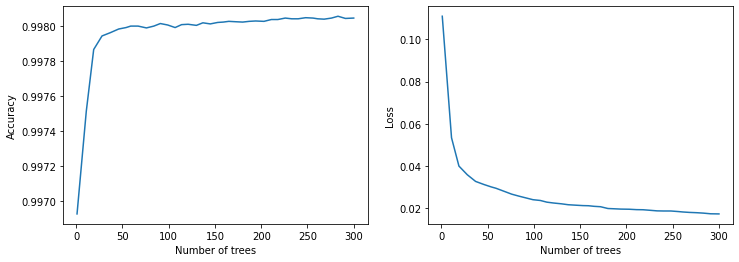

In [78]:
def plot_curve(logs):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot([log.num_trees for log in logs], [log.evaluation.accuracy for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")

    plt.subplot(1, 2, 2)
    plt.plot([log.num_trees for log in logs], [log.evaluation.loss for log in logs])
    plt.xlabel("Number of trees")
    plt.ylabel("Loss")

  


    plt.show()


plot_curve(logs_tf_rf)

In [79]:
print("model_1 summary: ")
print(model_tf_rf.summary())
print()

model_1 summary: 
Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (42):
	acc_now_delinq_index
	annual_inc
	application_type_index
	collection_recovery_fee
	collections_12_mths_ex_med_imputed
	delinq_2yrs
	dti
	emp_length_index
	funded_amnt
	funded_amnt_inv
	grade_index
	home_ownership_index
	id
	initial_list_status_index
	inq_last_6mths
	installment
	int_rate
	last_pymnt_amnt_imputed
	loan_amnt
	member_id
	open_acc
	out_prncp
	out_prncp_inv
	policy_code_imputed
	pub_rec
	purpose_index
	pymnt_plan_index
	recoveries
	revol_bal
	revol_util_imputed
	sub_grade_index
	term_index
	tot_coll_amt_imputed
	tot_cur_bal_imputed
	total_acc
	total_pymnt
	total_pymnt_inv
	total_rec_int
	total

In [80]:
results_tf_rf = model_tf_rf.evaluate(tf_test, return_dict=True, verbose=0)
print("Random Forest Tensorflow Evaluation: \n")
for name, value in results_tf_rf.items():
    print(f"{name}: {value:.4f}")

Random Forest Tensorflow Evaluation: 

loss: 0.0000
precision: 0.9999
recall: 0.9640
accuracy: 0.8551


In [81]:
prob_tf_rf = (model_tf_rf.predict(tf_test))
y_pred_tf_rf = prob_tf_rf.round(0)

258/258 [==============================] - 18s 68ms/step
